In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('seaborn')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Must properly set to home directory of "NeutronSpectraGeneration" 
import sys
sys.path.append("/g/g15/mcgreivy/NeutronSpectraGeneration/")

import unfolding_network
import data_generation
import constants

ModuleNotFoundError: No module named 'GAN_network'

## This is a method for feature paramter tuning which relies on a linear regression model to act as a proxy for the unfolding neural network. 

## This saves on computation time when evaluating the objective function (evaluate_GPA_params).

In [ ]:
def evaluate_GPA_params(meanPeakCenter, stdPeakCenter, meanPeakWidth, 
                      stdPeakWidth, extraPeakProb, ampDecay, ampSpread):
    
    lr = 0.001
    
    SPLITS = 3
    benchmark = []

    xeval, yeval = data_generation.x_data_IAEA, data_generation.y_data_IAEA
    
    for _ in range(SPLITS):
        # Use feature parameters to generate data from the GPA algorithm
        xdata, ydata = data_generation.gaussian_peak_algorithm(meanPeakCenter, stdPeakCenter, meanPeakWidth, 
                          stdPeakWidth, extraPeakProb, ampDecay, ampSpread,
                          numData = 2000)
        
        # w is the linear regression model, acts as a stand-in for a fully trained unfolding neural network.
        w = np.matmul(np.matmul(np.linalg.inv(np.matmul(xdata.T, xdata)), xdata.T), ydata)
        
        ypred = np.matmul(xeval, w)
        
        score = metrics.mean_squared_error(yeval, ypred)
        benchmark.append(score)
        
    print("{} ± {}".format(np.mean(benchmark), 2 * np.std(benchmark)))
        
    return -1e6 * np.mean(benchmark)

# bounds to search for feature parameters within (narrowed down from much larger bounds)
pbounds = {"ampDecay" : (0.72, 0.77),
           "ampSpread" : (0.41, 0.46),
           "extraPeakProb" : (0.84, 0.89),
           "meanPeakCenter" : (0.53, 0.6),
           "meanPeakWidth" : (0.01, 0.02),
           "stdPeakCenter" : (0.42, 0.46),
           "stdPeakWidth" : (0.004, 0.01)}

def optimize_model(init_points = 10, n_iter = 10):    

    optimizer = BayesianOptimization(f = evaluate_GPA_params,
                                    pbounds = pbounds,
                                    verbose = 2)

    optimizer.maximize(init_points = init_points, n_iter = n_iter)

    return optimizer.max


In [2]:
optimize_model()

NameError: name 'BayesianOptimization' is not defined

In [33]:
## ~~ PARAMETERS DETERMINED THROUGH THIS METHOD - LINEAR UNFOLDING ~~ ##

"""
{'target': -178.69182702321842,
 'params': {'ampDecay': 0.7595502174240601,
  'ampSpread': 0.43222437488141296,
  'extraPeakProb': 0.868724513095312,
  'meanPeakCenter': 0.5396739869861424,
  'meanPeakWidth': 0.015246762615043019,
  'stdPeakCenter': 0.44524257073882784,
  'stdPeakWidth': 0.007734903989927871}}
"""

params = {'ampDecay': 0.7595502174240601,
  'ampSpread': 0.43222437488141296,
  'extraPeakProb': 0.868724513095312,
  'meanPeakCenter': 0.5396739869861424,
  'meanPeakWidth': 0.015246762615043019,
  'stdPeakCenter': 0.44524257073882784,
  'stdPeakWidth': 0.007734903989927871}

x,y = data_generation.gaussian_peak_algorithm(**params, numData = 10)

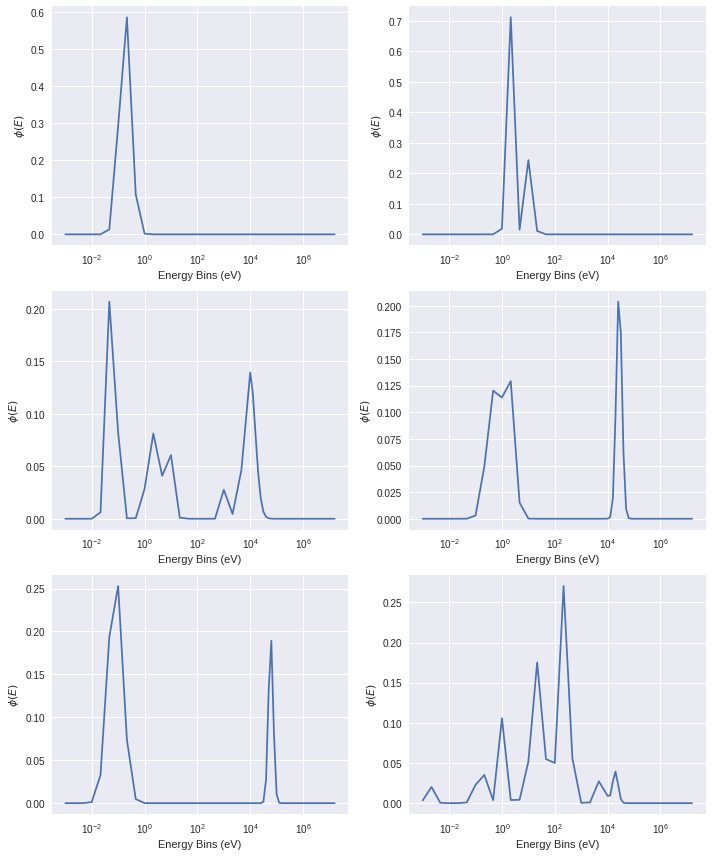

In [35]:
fig, axs = plt.subplots(3,2, figsize = (10,12))
i = 0
for ax in axs:
    for plot in ax:
        plot.plot(constants.Ebins, y[i])
        plot.set_xscale("log")
        plot.set_xlabel("Energy Bins (eV)")
        plot.set_ylabel("$\phi(E)$")
        i += 1

plt.tight_layout()
plt.savefig("GPA_NORMAL_Example", dpi = 300)